<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [20]:
front = '/content/gdrive/MyDrive/Front1.png'
side = '/content/gdrive/MyDrive/Side1.png'
height = 175

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision
import torch
import numpy as np
import cv2
import random
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.image as mpimg
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person'
]

def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

def findppm(mask, height):
  mask = mask.cpu().numpy()[0]
  masklen = len(mask) - 1
  trig1 = False
  trig2 = False
  while masklen >= 0:
    for j in mask[masklen]:
      if j > 0.5:
        trig1 = True
        break
    if trig1:
      break
    masklen -= 1
  topix = 0
  while topix < len(mask):
    for j in mask[topix]:
      if j > 0.5:
        trig2 = True
        break
    if trig2:
      break 
    topix += 1
  pixheight = masklen - topix
  ppmratio = pixheight/height
  return ppmratio

def findends(mask, height):
  masklen = len(mask) - 1
  trig1 = False
  trig2 = False
  trig3 = False
  trig4 = False
  while masklen >= 0:
    for j in mask[masklen]:
      if j == 1:
        trig1 = True
        break
    if trig1:
      break
    masklen -= 1

  topix = 0
  while topix < len(mask):
    for j in mask[topix]:
      if j == 1:
        trig2 = True
        break
    if trig2:
      break 
    topix += 1

  left = 0
  for i in range(len(mask[0])):
    for j in range((len(mask))):
      if mask[j][i] == 1:
        left = mask[j][i]
        trig4 = True
        break
    if trig4:
      break

  right = len(mask[0]) - 1
  while right >= 0:
    for j in range(len(mask)-1):
      if mask[j][right] == 1:
        trig3 = True
        break
    if trig3:
      break
    right -= 1
  return masklen, topix, left, right

def run_img(image1, image2, height):
  with torch.no_grad():
    img = image_loader(image1)
    front_network = Network()
    front_network.cuda()
    front_network.load_state_dict(torch.load('/content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned/front_landmarks5.pth')) 
    front_network.eval()
    predictions = (front_network(img[None, ...]).cpu())
    predictions = predictions.view(-1,6,2)
    predictions = predictions.detach().numpy()
    h_frontDot1 = predictions[0][2][0]
    h_frontDot2 = predictions[0][5][0]
    w_frontDot1 = predictions[0][1][0]
    w_frontDot2 = predictions[0][4][0]
    b_frontDot1 = predictions[0][0][0]
    b_frontDot2 = predictions[0][3][0]
    img1 = image_loader(image2)
    side_network = Network()
    side_network.cuda()
    side_network.load_state_dict(torch.load('/content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned/side_landmarks6.pth')) 
    side_network.eval()
    predictions1 = (side_network(img1[None, ...]).cpu())
    predictions1 = predictions1.view(-1,6,2)
    predictions1 = predictions1.detach().numpy()
    h_sideDot1 = predictions1[0][5][0]
    h_sideDot2 = predictions1[0][0][0]
    w_sideDot1 = predictions1[0][4][0]
    w_sideDot2 = predictions1[0][1][0]
    b_sideDot1 = predictions1[0][3][0]
    b_sideDot2 = predictions1[0][2][0]
    fimg = image1
    #fimg  = Image.open(fimg)
    transform = T.Compose([T.ToTensor()])
    fimg = transform(fimg)
    front_ppm = findppm(fimg, height)

    simg = image2
    #simg  = Image.open(simg)
    simg = transform(simg)
    side_ppm = findppm(simg, height)

    hips, waist, bust = gettest(front_ppm, h_frontDot1, h_frontDot2, w_frontDot1, w_frontDot2, b_frontDot1, b_frontDot2, side_ppm, h_sideDot1, h_sideDot2, w_sideDot1, w_sideDot2, b_sideDot1, b_sideDot2)
    return hips, waist, bust

def gettest(frontPPM, h_frontDot1, h_frontDot2, w_frontDot1, w_frontDot2, b_frontDot1, b_frontDot2, sidePPM, h_sideDot1, h_sideDot2, w_sideDot1, w_sideDot2, b_sideDot1, b_sideDot2):
  """
  model1 = torch.load('/content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned/hipspred_model.pt')
  model1.cuda()
  model1.eval()
  res =  model1(torch.tensor([frontPPM,	frontDot1,	frontDot2,	sidePPM,	sideDot1,	sideDot2]).cuda())
  print("Predicted Hips Loop: "+str(res.item()))
  """
  hips = (((h_frontDot1-h_frontDot2)/frontPPM)*2 + ((h_sideDot1-h_sideDot2)/sidePPM)*1.3)
  waist = (((w_frontDot1-w_frontDot2)/frontPPM)*2 + ((w_sideDot1-w_sideDot2)/sidePPM)*1.3)
  bust = (((b_frontDot1-b_frontDot2)/frontPPM)*2 + ((b_sideDot1-b_sideDot2)/sidePPM)*1.3)
  return hips, waist, bust

def image_loader(image):
    """
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = TF.resize(image, (512,512))
    """
    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    image = TF.to_tensor(image)
    image = Variable(image, requires_grad=True)
    return image.cuda()

In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jan 16 04:23:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |   1511MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
class Network(nn.Module):
    def __init__(self,num_classes=12):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [24]:
def align_image(imgo, height):
  ppm_std = 2.56
  img = Image.open(imgo)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if img.size()[0] == 4:
          img = img[:3, ...] 
  pred = model([img])
  labels = pred[0]['labels'].detach().numpy()
  scores = pred[0]['scores'].detach().numpy()
  indh = np.where(labels == 1)
  needed = np.where(scores[indh] > 0.8)
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  mask = masks[needed].astype('int')[0]
  boxes = pred[0]['boxes'].detach().numpy()
  box = boxes[needed].astype('int')[0]
  bottom, top, left, right = findends(mask, height)
  req_pixheight = int(ppm_std * height)
  image=mpimg.imread(imgo)
  image = image[top:bottom,box[0]:box[2]]
  req_width = int((req_pixheight * image.shape[1])/image.shape[0])
  image = Image.fromarray((image* 255).astype(np.uint8))
  image = TF.resize(image, (req_pixheight, req_width))
  alpha = image.split()[-1]
  alpha = np.array(alpha)
  width = len(alpha[0])
  height = len(alpha)
  midpoint_w = 0
  dist_h = 0
  if width < 512:
    dist_w = 512 - width
    midpoint_w = int(dist_w/2)
  if height < 512:
    dist_h = 512 - height
  alpha = np.pad(alpha, ((dist_h, 0),(midpoint_w, midpoint_w)), 'constant')
  alpha = Image.fromarray(alpha)
  alpha_image = Image.merge('RGB', (alpha, alpha, alpha))
  plt.imshow(alpha_image)
  plt.show()
  return alpha_image

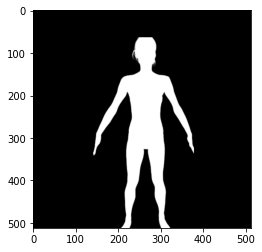

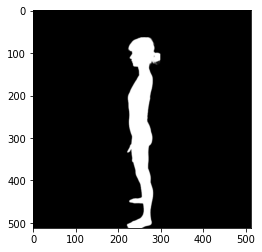

Missed hips by: 7.277729247773792 (cm)
Missed waist by: 0.4227923706874037 (cm)
Missed bust by: 17.96004301749619 (cm)


In [25]:
metrics = open('/content/gdrive/MyDrive/Female_S_6.txt','r').read().split("\n")
#metrics = open('/content/gdrive/MyDrive/AI_500_512px_SizesOnly_Aligned/AITrainingLib/100/Data.txt','r').read().split("\n")
hips_loop = int(metrics[3].split(": ")[1])
waist_loop = int(metrics[2].split(": ")[1])
bust_loop = int(metrics[1].split(": ")[1])
front = align_image(front, height)
side = align_image(side, height)
pred_hips, pred_waist, pred_bust = run_img(front, side, height)
print("Missed hips by: "+ str(abs(hips_loop - pred_hips)) + " (cm)")
print("Missed waist by: "+ str(abs(waist_loop - pred_waist)) + " (cm)")
print("Missed bust by: "+ str(abs(bust_loop - pred_bust)) + " (cm)")

# 500 Images metrics performance test

In [ ]:
hips_res = []
waist_res = []
bust_res = []
for i in range(1, 500):
  metrics = open('AITrainingLib/'+str(i)+'/Data.txt','r').read().split("\n")
  height = int(metrics[0].split(": ")[1])
  hips_loop = int(metrics[1].split(": ")[1])
  waist_loop = int(metrics[3].split(": ")[1])
  bust_loop = int(metrics[5].split(": ")[1])
  pred_hips, pred_waist, pred_bust = run_img('AITrainingLib/'+str(i)+'/Front.png', 'AITrainingLib/'+str(i)+'/Side.png', height)
  hips_res.append(abs(hips_loop - pred_hips))
  waist_res.append(abs(waist_loop - pred_waist))
  bust_res.append(abs(bust_loop - pred_bust))
  if i%100 == 0:
    print('Height:'+str(height))
    print('Actual Hips Loop:'+str(hips_loop))
    print("Predicted Hips Loop: "+str(pred_hips))
    print('Actual Waist Loop:'+str(waist_loop))
    print("Predicted Waist Loop: "+str(pred_waist))
    print('Actual Bust Loop:'+str(bust_loop))
    print("Predicted Bust Loop: "+str(pred_bust))

Height:180
Actual Hips Loop:99
Predicted Hips Loop: 100.39055822687776
Actual Waist Loop:80
Predicted Waist Loop: 77.50315733920323
Actual Bust Loop:79
Predicted Bust Loop: 74.5903325284465
Height:180
Actual Hips Loop:103
Predicted Hips Loop: 104.60072703711313
Actual Waist Loop:60
Predicted Waist Loop: 71.16830568792277
Actual Bust Loop:82
Predicted Bust Loop: 75.96142595062844
Height:180
Actual Hips Loop:93
Predicted Hips Loop: 94.12778581707218
Actual Waist Loop:66
Predicted Waist Loop: 74.44822056944699
Actual Bust Loop:100
Predicted Bust Loop: 95.31775262900915
Height:180
Actual Hips Loop:114
Predicted Hips Loop: 113.69934814790363
Actual Waist Loop:90
Predicted Waist Loop: 89.42348202858729
Actual Bust Loop:107
Predicted Bust Loop: 107.15766531011371


In [ ]:
print("Average Hips Loop Error: " + str(sum(hips_res) / len(hips_res)) +" (cm)")
print("Average Waist Loop Error: " + str(sum(waist_res) / len(waist_res)) +" (cm)")
print("Average Bust Loop Error: " + str(sum(bust_res) / len(bust_res)) +" (cm)")

Average Hips Loop Error: 1.2080626173616853 (cm)
Average Waist Loop Error: 5.190086949341243 (cm)
Average Bust Loop Error: 2.9545671270449505 (cm)
